# Regresión

Las técnicas de aprendizaje automático *supervisado* consisten en entrenar un modelo para que opere sobre un conjunto de *características* y predecir una *etiqueta* utilizando un conjunto de datos que incluye algunos valores de etiquetas ya conocidos. El proceso de capacitación *ajusta* las características a las etiquetas conocidas para definir una función general que se puede aplicar a nuevas características para las cuales se desconocen las etiquetas, y predecirlas. Puede pensar en esta función como esta, en la que ***y*** representa la etiqueta que queremos predecir y ***x*** representa las características que el modelo usa para predecirla:

$$y = f(x)$$

En la mayoría de los casos, *x* es en realidad un *vector* que consta de múltiples valores de características, por lo que para ser un poco más precisos, la función podría expresarse así:

$$y = f([x_1, x_2, x_3, ...])$$

El objetivo de entrenar al modelo es encontrar una función que realice algún tipo de cálculo a los valores *x* que produce el resultado *y*. Hacemos esto aplicando un *algoritmo de aprendizaje automático* que intenta ajustar los valores *x* a un cálculo que produce *y* razonablemente con precisión para todos los casos en el conjunto de datos de capacitación.

Hay muchos algoritmos de aprendizaje automático para el aprendizaje supervisado, y podemos dividirlos en dos tipos:

- **Algoritmos de _Regresión_**: Algoritmos que predicen un valor *y* que es un valor numérico, como el precio de una casa o el número de transacciones de ventas.
- **Algoritmos de _Clasificación_**: Algoritmos que predicen a qué categoría, o *clase*, pertenece una observación. El valor *y* en un modelo de clasificación es un vector de valores de probabilidad entre 0 y 1, uno para cada clase, lo que indica la probabilidad de la observación que pertenece a cada clase.

En este cuaderno, nos centraremos en *regresión*, utilizando un ejemplo basado en un estudio real en el que se recopilaron datos de un sistema de bicicletas compartidas y se utilizaron para predecir el número de alquileres basados en la estacionalidad y las condiciones metereológicas. Usaremos una versión simplificada del conjunto de datos de ese estudio.

> **Citación**: Los datos que utilizamos en este ejercicio se derivan de [Capital Bikeshare](https://www.capitalbikeshare.com/system-data) y se usa de acuerdo con el publicado [license agreement](https://www.capitalbikeshare.com/data-license-agreement).

## Explorar los datos

El primer paso en cualquier proyecto de aprendizaje automático es explorar los datos que utilizará para entrenar un modelo. El objetivo de esta exploración es tratar de comprender las relaciones entre sus atributos; en particular, cualquier correlación aparente entre las *características* y la *etiqueta* que su modelo intentará predecir. Esto puede requerir un trabajo para detectar y solucionar problemas en los datos (como tratar con valores faltantes, errores o valores atípicos), derivando nuevas columnas de características transformando o combinando las características existentes (un proceso conocido como *Ingeniería de características*), *normalizando* características numéricas (valores que puede medir o contar) para que estén en una escala similar y *codificando* características categóricas (valores que representan categorías discretas) como indicadores numéricos.

Comencemos cargando los datos del uso compartido de bicicletas como un **Pandas** DataFrame y viendo las primeras filas.

In [3]:
import pandas as pd

# load the training dataset
# !wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/ml-basics/daily-bike-share.csv
bike_data = pd.read_csv('daily-bike-share.csv')
bike_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82


Los datos consisten en las siguientes columnas:

- **instant**: Un identificador de fila único
- **dteday**: La fecha en que se observaron los datos; en este caso, los datos se recopilaron diariamente, por lo que hay una fila por fecha.
- **season**: Un valor codificado numéricamente que indica la temporada (1:invierno, 2:primavera, 3:verano, 4:otoño)
- **yr**: El año del estudio en el que se realizó la observación (el estudio tuvo lugar durante dos años: el año 0 representa 2011, y el año 1 representa 2012)
- **mnth**: El mes calendario en el que se realizó la observación (1:Enero ... 12:Diciembre)
- **holiday**: Un valor binario que indica si la observación se hizo o no en un día festivo
- **weekday**: El día de la semana en el que se hizo la observación (0:Domingo ... 6:Sábado)
- **workingday**: Un valor binario que indica si el día es o no un día de trabajo (no un fin de semana o feriado)
- **weathersit**: Un valor categórico que indica la situación del clima (1:claro, 2:niebla/nube, 3:lluvia ligera/nieve, 4:lluvia pesada/granizo/nieve/niebla)
- **temp**: La temperatura en Celsius (normalizado)
- **atemp**: La temperatura aparente ("similar a la sensación") en Celsius (normalizado)
- **hum**: El nivel de humedad (normalizado)
- **windspeed**: La velocidad del viento (normalizado)
- **rentals**: El número de alquileres de bicicletas registrados.

En este conjunto de datos, **rentals** representa la etiqueta (el valor *y*) que debemos entrenar para que prediga nuestro modelo. Las otras columnas son características potenciales (valores *x*).

Como mencionamos anteriormente, se puede realizar una *ingeniería de características* para combinar o derivar nuevas características.Por ejemplo, agregemos una nueva columna llamada **day** al marco de datos extrayendo el componente día de la columna **dteday** existente. La nueva columna representa el día del mes, del 1 al 31.

In [4]:
bike_data['day'] = pd.DatetimeIndex(bike_data['dteday']).day
bike_data.head(32)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals,day
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,1
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,2
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,3
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,4
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,5
5,6,1/6/2011,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.089565,88,6
6,7,1/7/2011,1,0,1,0,5,1,2,0.196522,0.208839,0.498696,0.168726,148,7
7,8,1/8/2011,1,0,1,0,6,0,2,0.165000,0.162254,0.535833,0.266804,68,8
8,9,1/9/2011,1,0,1,0,0,0,1,0.138333,0.116175,0.434167,0.361950,54,9
9,10,1/10/2011,1,0,1,0,1,1,1,0.150833,0.150888,0.482917,0.223267,41,10


Ok, comencemos nuestro análisis de los datos examinando algunas estadísticas descriptivas claves. Podemos usar el método DataFrame **describe** para generarlos para las características numéricas, así como para la columna de etiqueta **rentals**.

In [5]:
numeric_features = ['temp', 'atemp', 'hum', 'windspeed']
bike_data[numeric_features + ['rentals']].describe()

,temp,atemp,hum,windspeed,rentals
count,731.000000,731.000000,731.000000,731.000000,731.000000
mean,0.495385,0.474354,0.627894,0.190486,848.176471
std,0.183051,0.162961,0.142429,0.077498,686.622488
min,0.059130,0.079070,0.000000,0.022392,2.000000
25%,0.337083,0.337842,0.520000,0.134950,315.500000
50%,0.498333,0.486733,0.626667,0.180975,713.000000
75%,0.655417,0.608602,0.730209,0.233214,1096.000000
max,0.861667,0.840896,0.972500,0.507463,3410.000000


Las estadísticas revelan cierta información sobre la distribución de los datos en cada uno de los campos numéricos, incluido el número de observaciones (hay 731 registros), la media, desviación estándar, valores mínimos y máximos, y los valores del cuartil (los valores de umbral para 25%, 50%, que también es la mediana y el 75% de los datos).A partir de esto, podemos ver que el número medio de alquileres diarios es de alrededor de 848; pero hay una desviación estándar relativamente grande, que indica una gran variación en el número de alquileres por día.

Podríamos tener una idea más clara de la distribución de los valores de los alquileres visualizando los datos. Los tipos de gráficos más comunes para visualizar las distribuciones de datos numéricos son *histograms* y *box plots*, así que usemos la biblioteca **matplotlib** de Python para crear uno de estos para la columna **rentals**.

/tmp/ipykernel_145344/2229708211.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


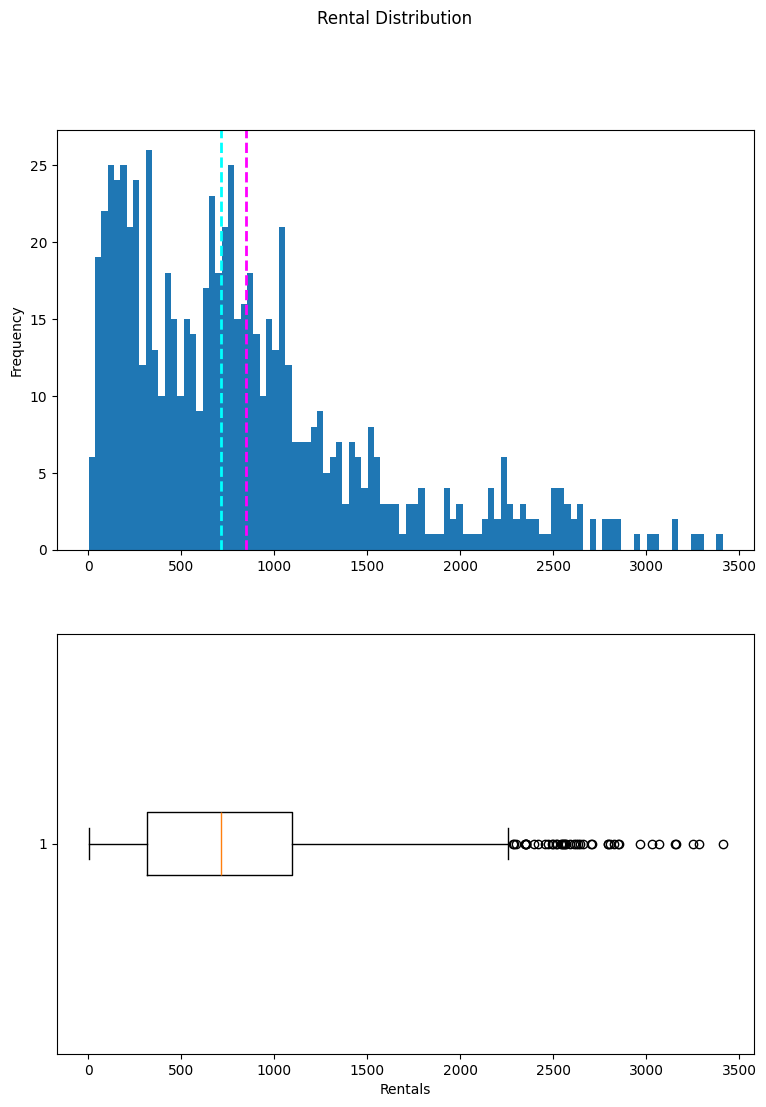

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# This ensures plots are displayed inline in the Jupyter notebook
%matplotlib inline

# Get the label column
label = bike_data['rentals']


# Create a figure for 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize = (9,12))

# Plot the histogram   
ax[0].hist(label, bins=100)
ax[0].set_ylabel('Frequency')

# Add lines for the mean, median, and mode
ax[0].axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax[0].axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2)

# Plot the boxplot   
ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('Rentals')

# Add a title to the Figure
fig.suptitle('Rental Distribution')

# Show the figure
fig.show()


Las tramas muestran que el número de alquileres diarios oscila entre 0 y algo más de 3,400. Sin embargo, el número medio (y la mediana) del número de alquileres diarios está más cerca del extremo inferior de ese intervalo, con la mayoría de los datos entre 0 y alrededor de 2.200 alquileres. Los pocos valores por encima de esta cifra se muestran en el diagrama de caja como círculos pequeños, lo que indica que son *valores atípicos*; en otras palabras, valores inusualmente altos o bajos más allá del rango típico de la mayoría de los datos.

Podemos hacer el mismo tipo de exploración visual de las características numéricas. Creemos un histograma para cada uno de estos.

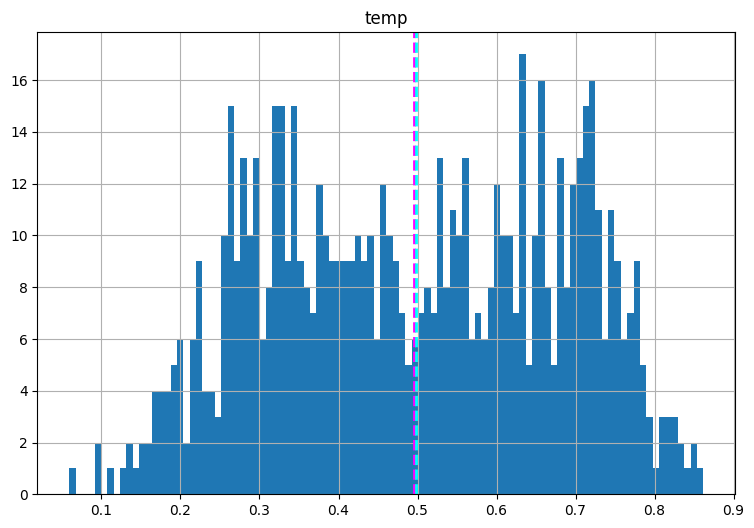

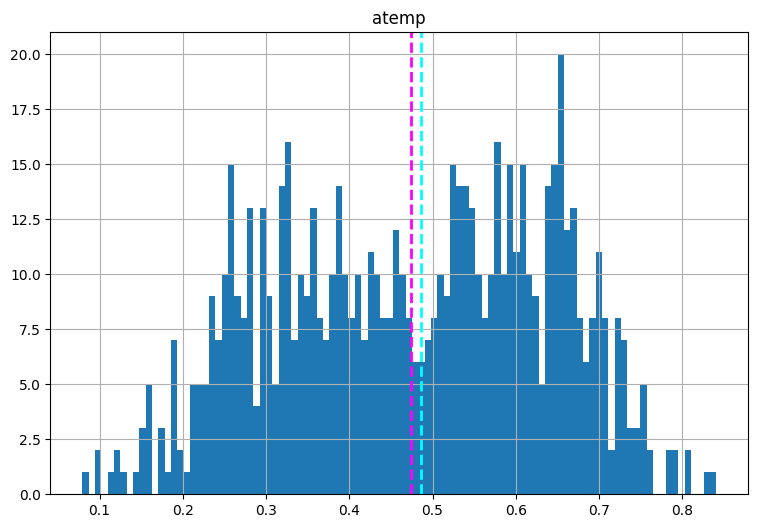

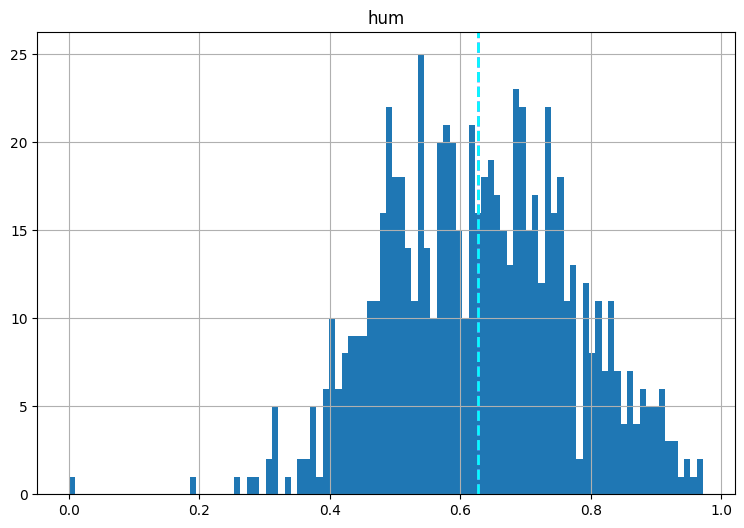

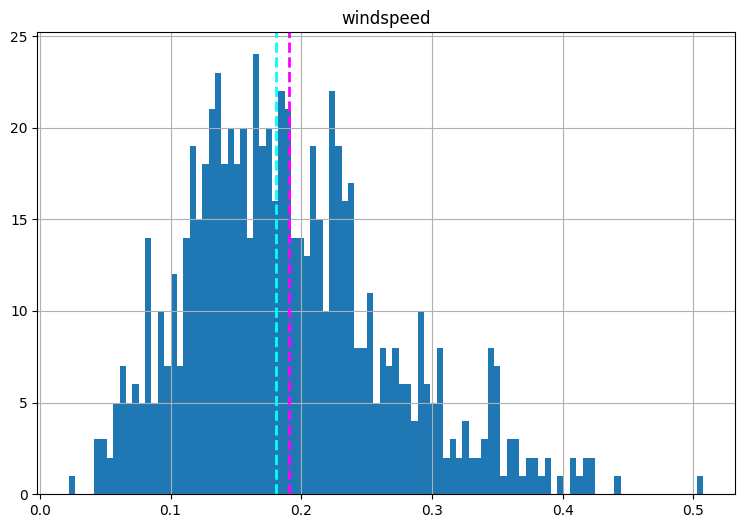

In [7]:
# Plot a histogram for each numeric feature
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = bike_data[col]
    feature.hist(bins=100, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)
    ax.set_title(col)
plt.show()

Las características numéricas parecen estar más *normalmente* distribuidas, con la media y la mediana más cerca del rango de valores, coincidiendo con donde están los valores más comúnmente ocurridos.

> **Nota**: Las distribuciones no son verdaderamente *normales* en el sentido estadístico, lo que daría como resultado un histograma suave y simétrico de "curva de campana" con la media y la moda (el valor más común) en el centro; pero generalmente indican que la mayoría de las observaciones tienen un valor en algún lugar cerca del medio.

Hemos explorado la distribución de los valores numéricos en el conjunto de datos, pero ¿qué pasa con las características categóricas?Estos no son números continuos en una escala, por lo que no podemos usar histogramas; pero podemos trazar un gráfico de barras que muestra el recuento de cada valor discreto para cada categoría.

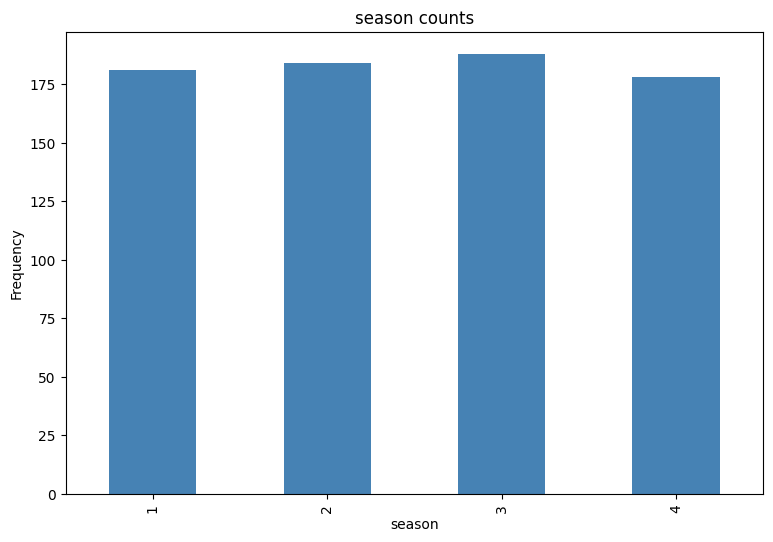

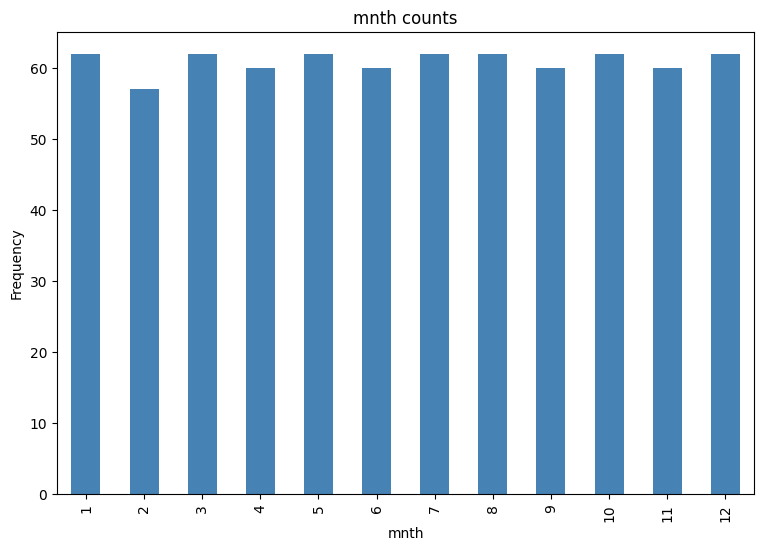

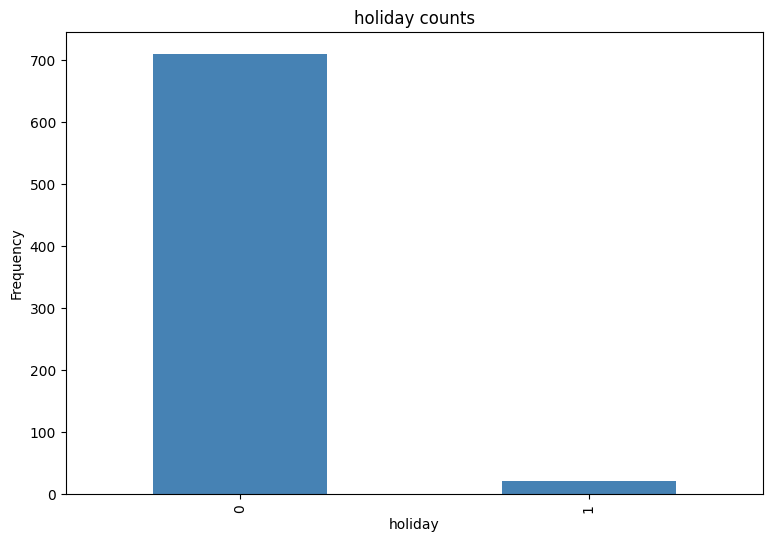

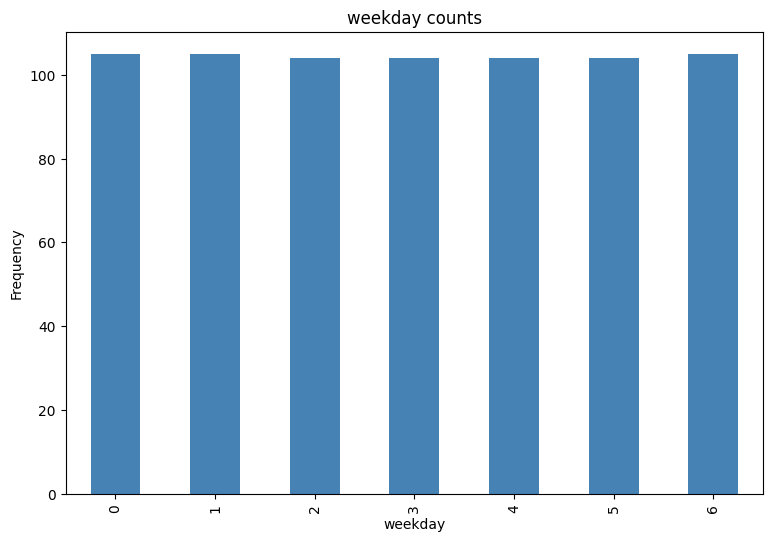

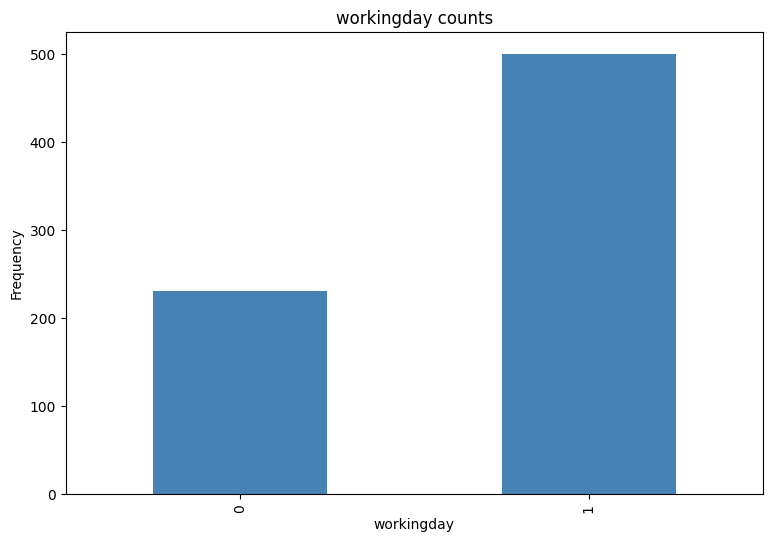

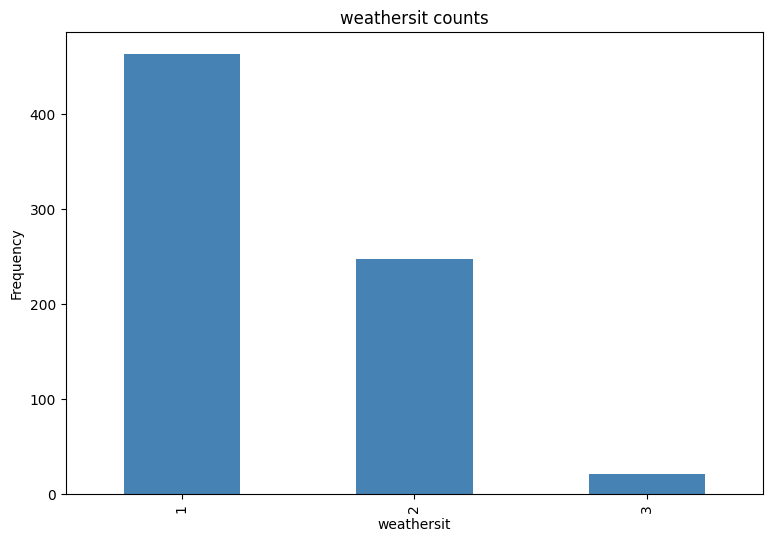

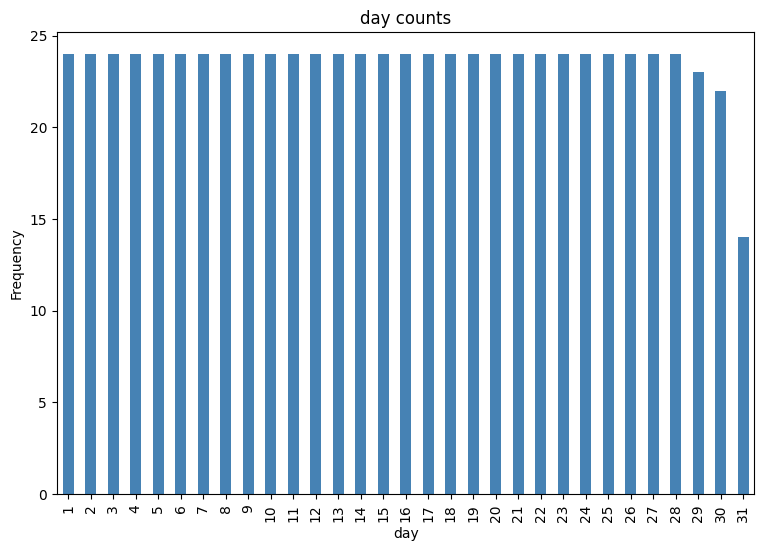

In [8]:
import numpy as np

# plot a bar plot for each categorical feature count
categorical_features = ['season','mnth','holiday','weekday','workingday','weathersit', 'day']

for col in categorical_features:
    counts = bike_data[col].value_counts().sort_index()
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    counts.plot.bar(ax = ax, color='steelblue')
    ax.set_title(col + ' counts')
    ax.set_xlabel(col) 
    ax.set_ylabel("Frequency")
plt.show()


Muchas de las características categóricas muestran una distribución más o menos *uniforme* (lo que significa que hay aproximadamente el mismo número de filas para cada categoría). Las excepciones a esto incluyen:

- **holiday**: Hay muchos menos días que sean festivos que días que no lo sean.
- **workingday**:  Hay más días laborables que no laborables.
- **weathersit**: La mayoría de los días son de categoría *1* (claro), siendo la categoría *2* (niebla y nube) la siguiente más común. Hay relativamente pocas días de categoría *3* (lluvia ligera o nieve), y ninguno de categoría *4* (lluvia pesada, granizo o niebla).

Ahora que sabemos algo sobre la distribución de los datos en nuestras columnas, podemos comenzar a buscar relaciones entre las características y la etiqueta **rentals** que queremos poder predecir.

Para las características numéricas, podemos crear gráficos de dispersión que muestren la intersección de los valores de las características y las etiquetas. También podemos calcular la estadística *correlación* para cuantificar la relación aparente.

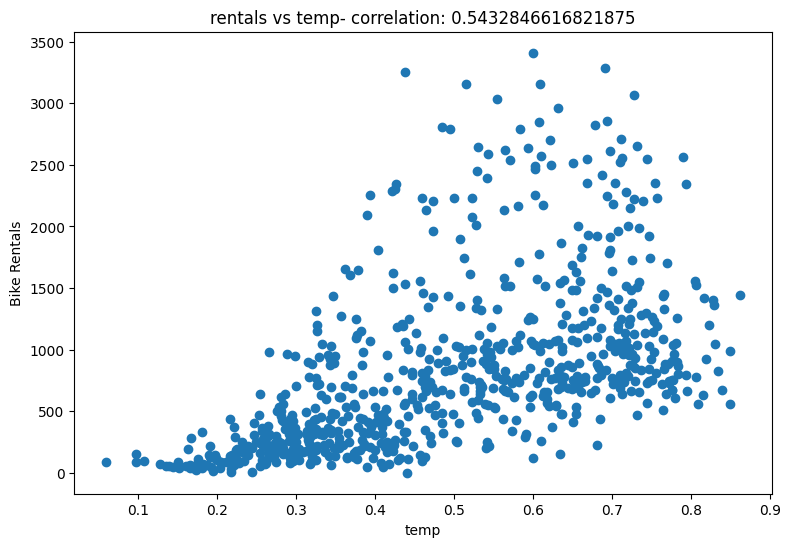

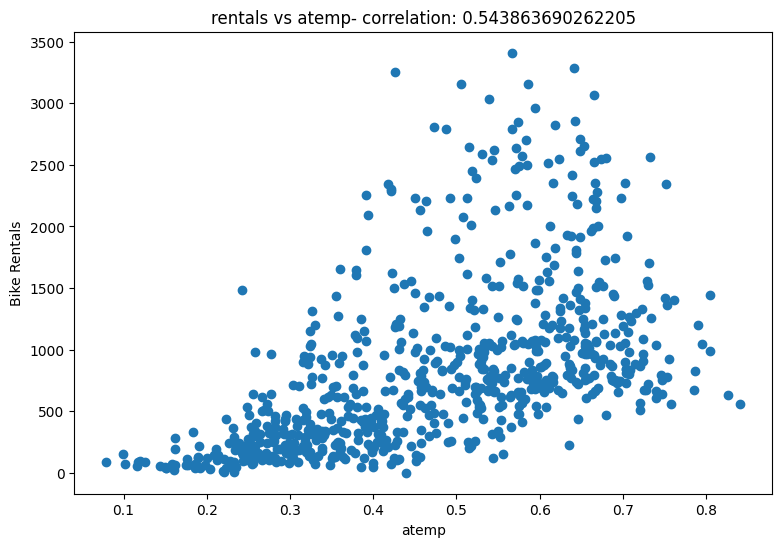

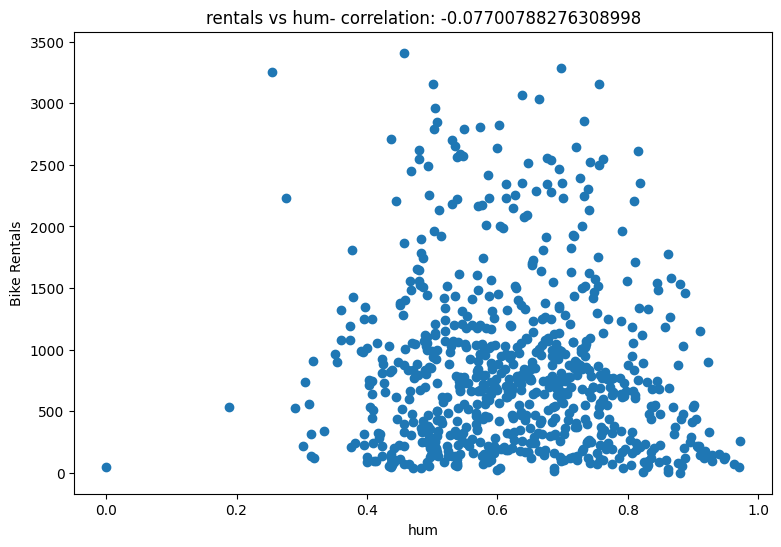

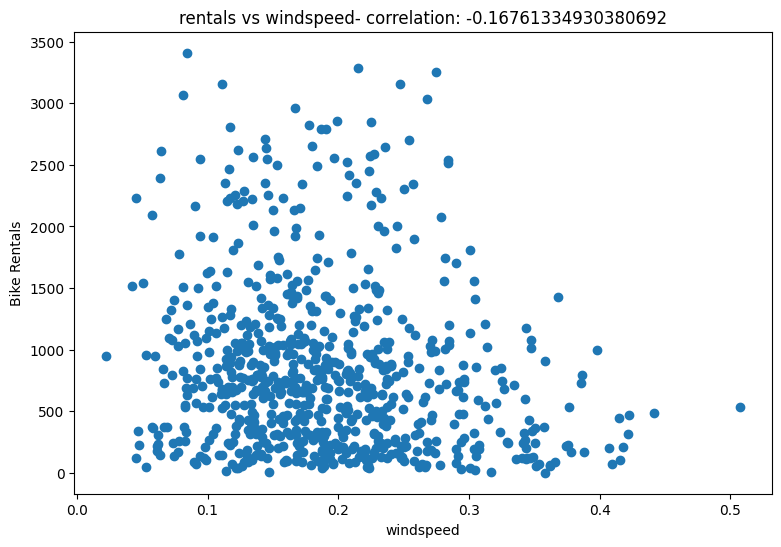

In [9]:
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = bike_data[col]
    label = bike_data['rentals']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Bike Rentals')
    ax.set_title('rentals vs ' + col + '- correlation: ' + str(correlation))
plt.show()


Los resultados no son concluyentes, pero si se observan detenidamente los gráficos de dispersión de **temp** y **atemp**, se puede ver una vaga tendencia diagonal que muestra que un mayor número de alquileres tiende a coincidir con temperaturas más altas, y un valor de correlación ligeramente superior a 0.5 para ambas características respalda esta observación. Por el contrario, los gráficos correspondientes a **hum** y **windspeed** muestran una correlación ligeramente negativa, lo que indica que hay menos alquileres en los días en que la humedad o la velocidad del viento son elevadas.

Ahora vamos a comparar las características categóricas con la etiqueta. Para ello, crearemos gráficos de caja que muestren la distribución del número de alquileres para cada categoría.

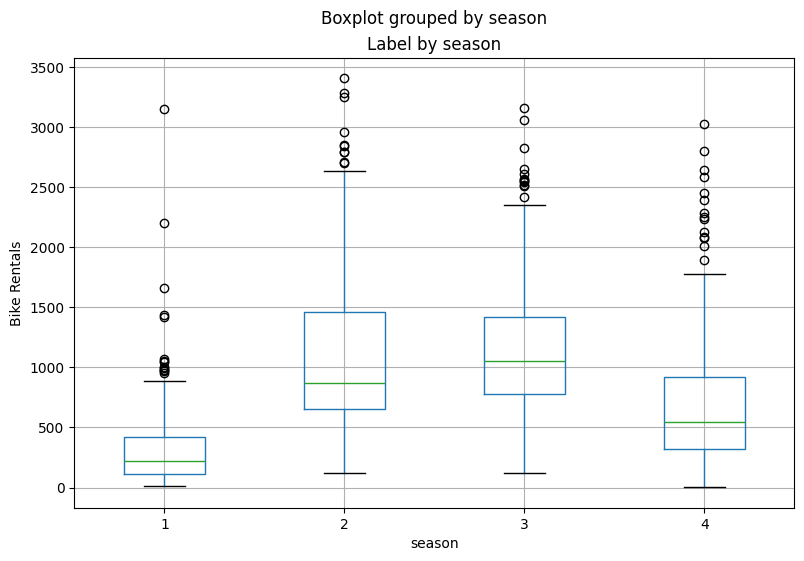

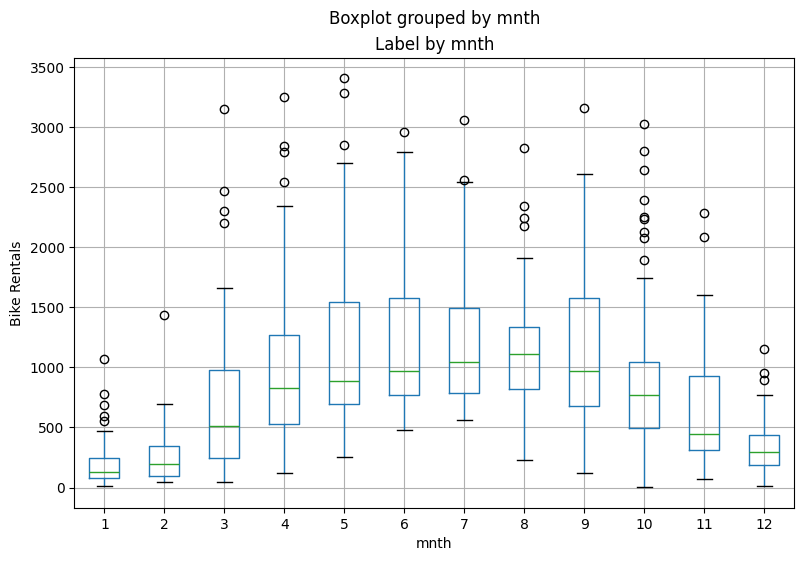

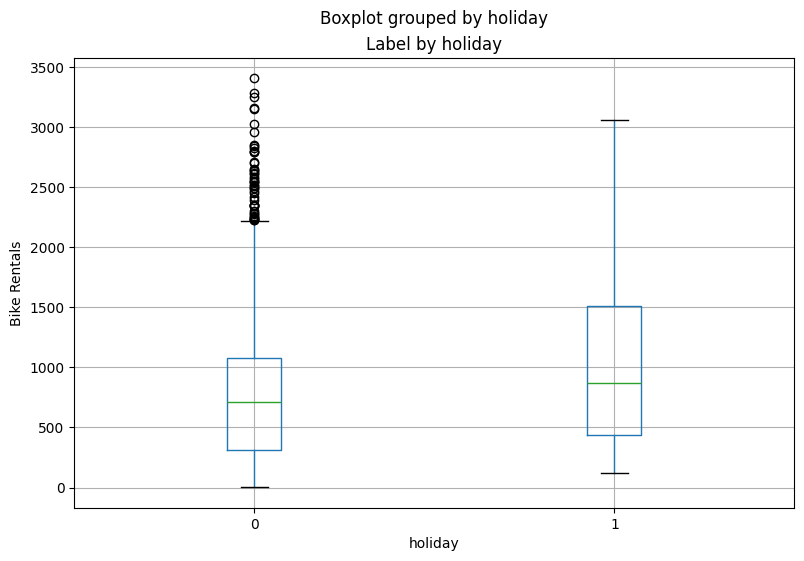

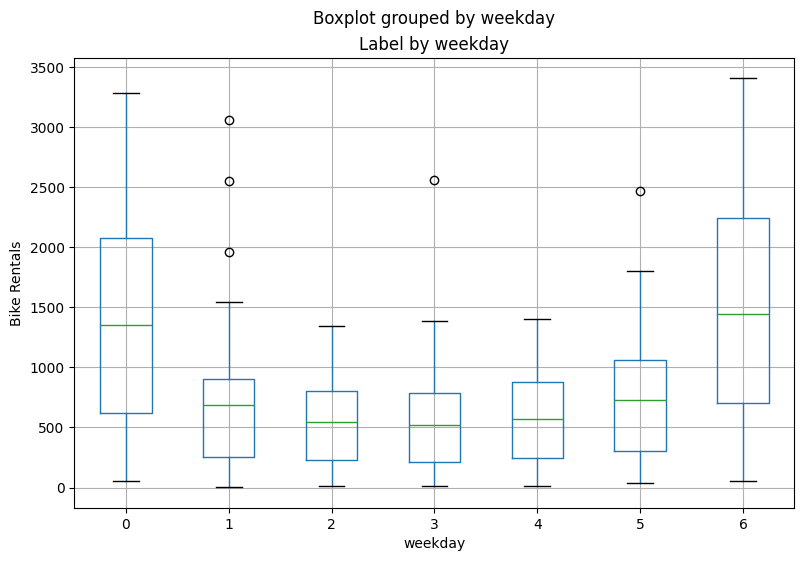

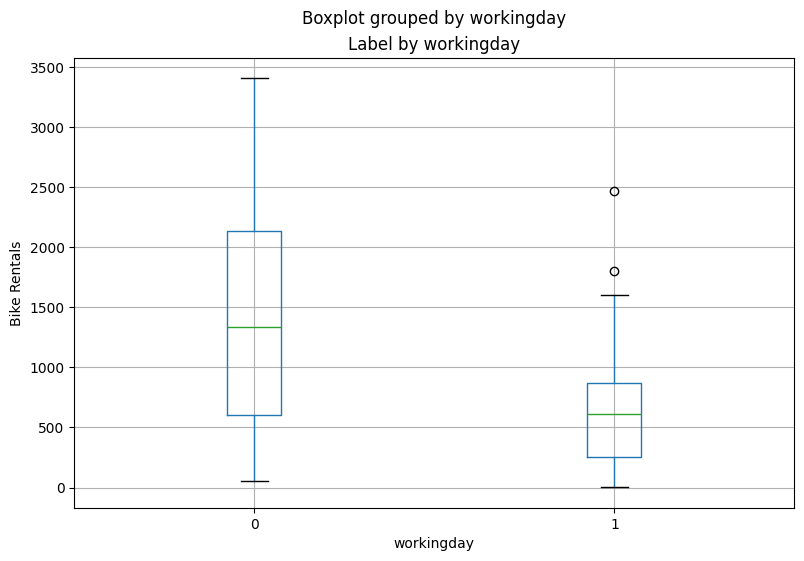

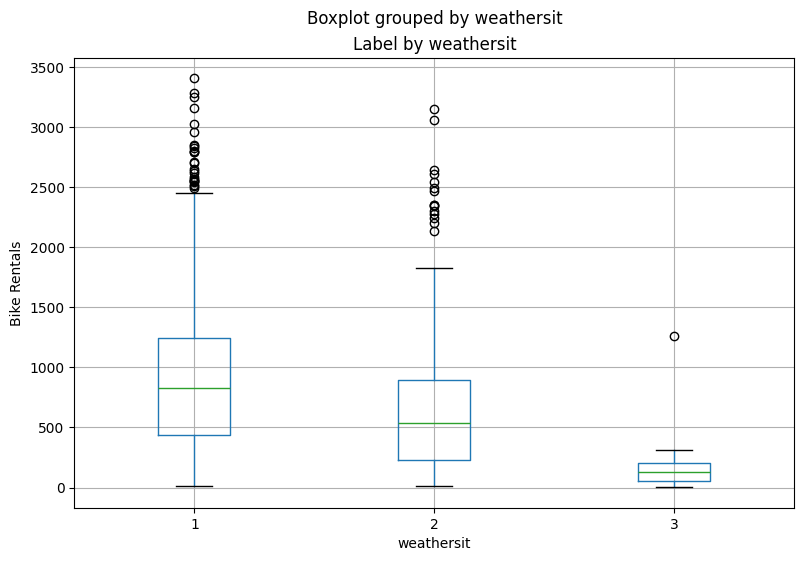

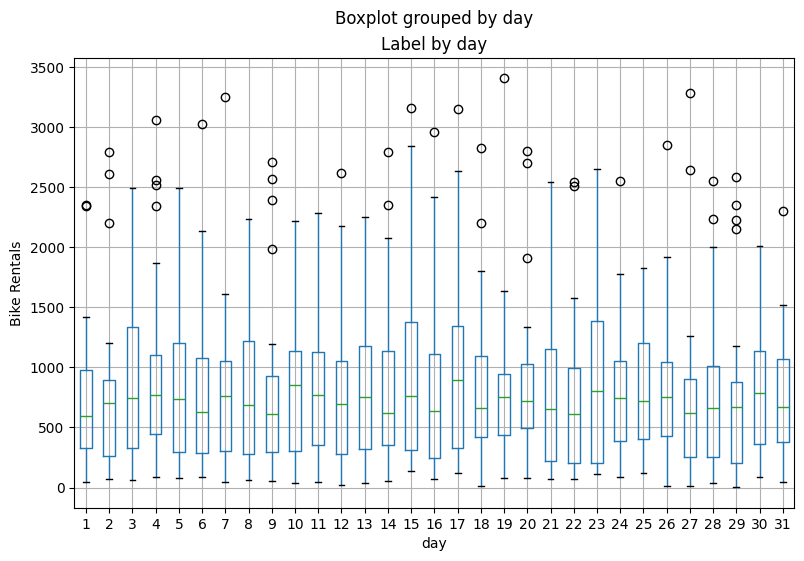

In [10]:
# plot a boxplot for the label by each categorical feature
for col in categorical_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    bike_data.boxplot(column = 'rentals', by = col, ax = ax)
    ax.set_title('Label by ' + col)
    ax.set_ylabel("Bike Rentals")
plt.show()

Los gráficos muestran cierta variación en la relación entre los valores de algunas categorías y alquileres. Por ejemplo, hay una clara diferencia en la distribución de alquileres los fines de semana (**weekday** 0 o 6) y aquellos durante la semana laboral (**weekday** 1 a 5). Del mismo modo, existen diferencias notables en las categorías **holiday** y **workingday**. Hay una tendencia notable que muestra diferentes distribuciones de alquiler en los meses de primavera y verano en comparación con los meses de invierno y otoño. La categoría **weathersit** también parece marcar una diferencia en la distribución de alquiler. La característica **day** que creamos para el día del mes muestra poca variación, lo que indica que probablemente no sea predictiva de la cantidad de alquileres.

## Entrenar un modelo de regresión

Ahora que hemos explorado los datos, es hora de usarlos para entrenar un modelo de regresión que utilice las características que hemos identificado como potencialmente predictivas para predecir la etiqueta **rentals**. Lo primero que debemos hacer es separar las características que queremos utilizar para entrenar el modelo de la etiqueta que queremos que prediga.

In [11]:
# Separate features and labels
X, y = bike_data[['season','mnth', 'holiday','weekday','workingday','weathersit','temp', 'atemp', 'hum', 'windspeed']].values, bike_data['rentals'].values
print('Features:',X[:10], '\nLabels:', y[:10], sep='\n')

Features:
[[1.        1.        0.        6.        0.        2.        0.344167
  0.363625  0.805833  0.160446 ]
 [1.        1.        0.        0.        0.        2.        0.363478
  0.353739  0.696087  0.248539 ]
 [1.        1.        0.        1.        1.        1.        0.196364
  0.189405  0.437273  0.248309 ]
 [1.        1.        0.        2.        1.        1.        0.2
  0.212122  0.590435  0.160296 ]
 [1.        1.        0.        3.        1.        1.        0.226957
  0.22927   0.436957  0.1869   ]
 [1.        1.        0.        4.        1.        1.        0.204348
  0.233209  0.518261  0.0895652]
 [1.        1.        0.        5.        1.        2.        0.196522
  0.208839  0.498696  0.168726 ]
 [1.        1.        0.        6.        0.        2.        0.165
  0.162254  0.535833  0.266804 ]
 [1.        1.        0.        0.        0.        1.        0.138333
  0.116175  0.434167  0.36195  ]
 [1.        1.        0.        1.        1.        1.        

Después de separar el conjunto de datos, ahora tenemos matrices numpy llamadas **x** que contienen las características y **y** que contienen las etiquetas.

*Podríamos* entrenar un modelo utilizando todos los datos, pero es una práctica común en el aprendizaje supervisado dividir los datos en dos subconjuntos: un conjunto (normalmente más grande) con el que entrenar el modelo, y un conjunto más pequeño "retenido" con el cual validar el modelo entrenado. Esto nos permite evaluar el rendimiento del modelo cuando se utiliza con el conjunto de datos de validación comparando las etiquetas predichas con las etiquetas conocidas. Es importante dividir los datos *aleatoriamente* (en lugar de, por ejemplo, tomar el primer 70% de los datos para el entrenamiento y reservar el resto para la validación). Esto ayuda a garantizar que los dos subconjuntos de datos sean estadísticamente comparables (por lo que validamos el modelo con datos que tienen una distribución estadística similar a los datos con los que se entrenó).

Para dividir aleatoriamente los datos, utilizaremos la función **train_test_split** en la biblioteca **scikit-learn**. Esta biblioteca es uno de los paquetes de aprendizaje automático más utilizados para Python.

In [12]:
from sklearn.model_selection import train_test_split

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 511 rows
Test Set: 220 rows


Ahora tenemos los siguientes cuatro conjuntos de datos:

- **X_train**: Los valores de la característica que utilizaremos para entrenar el modelo
- **y_train**: Las etiquetas correspondientes utilizaremos para entrenar el modelo
- **X_test**: Los valores de la característica que utilizaremos para validar el modelo
- **y_test**: Las etiquetas correspondientes que utilizaremos para validar el modelo

Ahora estamos listos para entrenar un modelo ajustando un algoritmo de regresión adecuado a los datos de entrenamiento. Utilizaremos un algoritmo de regresión *lineal*, un punto de partida común para la regresión que funciona intentando encontrar una relación lineal entre los valores *x* y la etiqueta *y*. El modelo resultante es una función que define conceptualmente una línea en la que se cruzan todas las posibles combinaciones de X e Y.

En Scikit-Learn, los algoritmos de entrenamiento se encapsuladn en *estimadores*, y en este caso, usaremos el estimador **LinearRegression** para entrenar un modelo de regresión lineal.

In [13]:
# Train the model
from sklearn.linear_model import LinearRegression

# Fit a linear regression model on the training set
model = LinearRegression().fit(X_train, y_train)
print (model)

LinearRegression()


### Evaluar el modelo entrenado

Ahora que hemos entrenado el modelo, podemos usarlo para predecir los recuentos de alquileres para las características que retuvimos en nuestro conjunto de datos de validación. A continuación, podemos comparar estas predicciones con los valores de reales de las etiquetas para evaluar qué tan bien (o no!) el modelo está funcionando.

In [14]:
import numpy as np

predictions = model.predict(X_test)
np.set_printoptions(suppress=True)
print('Predicted labels: ', np.round(predictions)[:10])
print('Actual labels   : ' ,y_test[:10])

Predicted labels:  [1896. 1184. 1007.  -28.  314.  385.  475.  590. 1476.  -22.]
Actual labels   :  [2418  754  222   47  244  145  240  555 3252   38]


Comparar cada predicción con su correspondiente valor real no es una forma muy eficaz de determinar lo bien que predice el modelo. Veamos si podemos obtener una mejor indicación visualizando un gráfico de dispersión que compare las predicciones con las etiquetas reales. También superpondremos una línea de tendencia para una idea general de qué tan bien se alinean las etiquetas predichas con las verdaderas etiquetas.

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

Hay una tendencia diagonal definitiva, y las intersecciones de los valores predichos y reales generalmente siguen la trayectoria de la línea de tendencia, pero hay bastante diferencia entre la función ideal representada por la línea y los resultados. Esta diferencia representa los *residuos* del modelo; en otras palabras, la diferencia entre la etiqueta prevista cuando el modelo aplica los coeficientes aprendidos durante el entrenamiento a los datos de validación y el valor real de la etiqueta de validación. Estos residuos evaluados a partir de los datos de validación, indican el nivel esperado de *error* cuando el modelo se utiliza con nuevos datos para los cuales se desconoce la etiqueta.

Puede cuantificar los residuos calculando una serie de métricas de evaluación de uso común. Nos centraremos en las tres siguientes:

- **Mean Square Error (MSE)**: La media de las diferencias al cuadrado entre los valores predichos y reales. Se trata de una medida relativa en la que cuanto menor es el valor, mejor es el ajuste del modelo.
- **Root Mean Square Error (RMSE)**: La raíz cuadrada del MSE. Proporciona una medida absoluta en la misma unidad que la etiqueta (en este caso, números de alquileres). Cuanto menor sea el valor, mejor es el modelo (en un sentido simplista, representa el número promedio de alquileres en el que las predicciones son erróneas).
- **Coefficient of Determination (generalmente conocido como *R-squared* o R<sup>2</sup>**): Una métrica relativa en la que cuanto mayor sea el valor, mejor es el ajuste del modelo. En esencia, esta métrica representa que parte de la varianza entre los valores  predichos y reales de las etiquetas es capaz de explicar el modelo.

> **Nota**: Puede obtener más información sobre estas y otras métricas para evaluar los modelos de regresión en la [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)

Utilicemos Scikit-Learn para calcular estas métricas para nuestro modelo basándonos en las predicciones que generó para los datos de validación.

In [15]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, predictions)
print("R2:", r2)

MSE: 201972.55947035592
RMSE: 449.4135728595165
R2: 0.6040454736919191


Ahora hemos cuantificado la capacidad de nuestro modelo para predecir el número de alquileres. Definitivamente tiene *cierto* poder predictivo, ¡pero probablemente podamos hacerlo mejor!

## Resumen

Aquí, hemos explorado nuestros datos y ajustado un modelo de regresión básico. En el próximo cuaderno, probaremos otros algoritmos de regresión para mejorar el rendimiento.

## Lecturas adicionales

Para obtener más información sobre Scikit-Learn, consulte [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics).